In [47]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit

# Use average of scores as benchmark
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import model_selection


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn import cross_validation

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


In [48]:
pisa = pd.read_csv('pisa2009.csv')
print('Shape of dataset: ',pisa.shape)

('Shape of dataset: ', (5233, 24))


## Benchmark

In [49]:
# Use average of scores as benchmark
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LinearRegression()

withoutNa = pisa.dropna()
X = withoutNa.drop(['readingScore', 'raceeth'], axis=1)
y = withoutNa['readingScore']

kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')

print cv_rmse.mean()
print cv_r2.mean()


print(pisa.shape)


77.3750215458
0.241581166205
(5233, 24)


# III. Methodology
## Data Preprocessing

### Handling Missing Values

In [50]:
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0 in place of missing value
pisa = pisa.apply(lambda x:x.fillna(0))


### Binning Continuous Variables

#### minutesPerWeekEnglish

In [51]:

bins = [-1, 100, 200, 300, 400, 500, 2500 ]
group_names = ['<100', '100-200', '200-300', '300-400', '400-500', '500-2500']
pisa['englishBins'] = pd.cut(pisa['minutesPerWeekEnglish'], bins, labels=group_names)
pisa.drop('minutesPerWeekEnglish', axis=1)
pisa['englishBins'].value_counts()


200-300     3337
<100         518
100-200      500
300-400      375
400-500      352
500-2500     151
Name: englishBins, dtype: int64

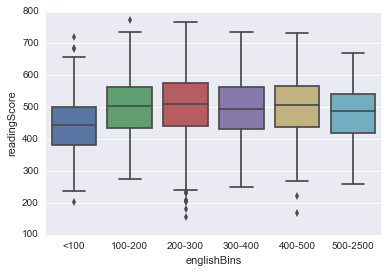

In [52]:
sns.boxplot('englishBins', 'readingScore', data=pisa)

#### studentsInEnglish

In [53]:
bins = [0, 10, 20, 30, 40, 50, 100 ]
group_names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-100']
pisa['englishStudents'] = pd.cut(pisa['studentsInEnglish'], bins, labels=group_names)
pisa.drop('studentsInEnglish', axis=1)
pisa['englishStudents'].value_counts()

20-30     3105
10-20     1549
30-40      418
<10        116
40-50       23
50-100      22
Name: englishStudents, dtype: int64

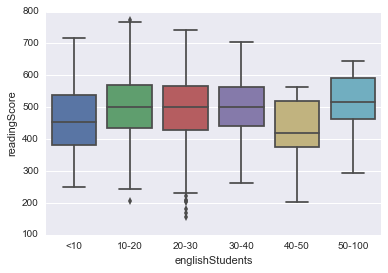

In [54]:
sns.boxplot('englishStudents', 'readingScore', data=pisa)

#### schoolSize

In [55]:
bins = [0, 100, 500, 1000, 2000, 3000, 7000 ]
group_names = ['<100', '100-500', '500-1000', '1000-2000', '2000-3000', '3000-7000']
pisa['schoolBin'] = pd.cut(pisa['schoolSize'], bins, labels=group_names)
pisa.drop('schoolSize', axis=1)
pisa['schoolBin'].value_counts()

1000-2000    2096
500-1000     1251
2000-3000     843
100-500       794
3000-7000     237
<100           12
Name: schoolBin, dtype: int64

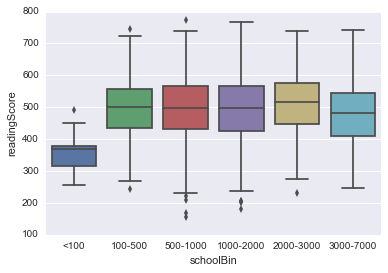

In [56]:
sns.boxplot('schoolBin', 'readingScore', data=pisa)

### Handling categorical variables

In [57]:
# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

minutes = pd.get_dummies(pisa['englishBins'], 'minutes')
pisa = pd.concat([pisa, minutes], axis=1)
pisa = pisa.drop('englishBins', axis=1)

students = pd.get_dummies(pisa['englishStudents'], 'students')
pisa = pd.concat([pisa, students], axis=1)
pisa = pisa.drop('englishStudents', axis=1)

school = pd.get_dummies(pisa['schoolBin'], 'school')
pisa = pd.concat([pisa, school], axis=1)
pisa = pisa.drop('schoolBin', axis=1)

grade = pd.get_dummies(pisa['grade'], 'grade')
pisa = pd.concat([pisa, school], axis=1)
pisa = pisa.drop('grade', axis=1)

### Handling multicolinearity

In [58]:
# remove multicolinearity marked for removal in exploration phase
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

### Training Test set split

In [59]:
y = pisa['readingScore']
X = pisa.drop('readingScore', axis=1).values
#pisa = pisa.drop(['readingScore'], axis=1)
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Implementation

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
def spot_check_models(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('ElasticNet', ElasticNet()))
    models.append(('Bayesian Ridge', BayesianRidge()))
    models.append(('Ridge', Ridge()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DecisionTree', DecisionTreeRegressor()))
    models.append(('SupprtVector', SVR()))
    models.append(('AdaBoost', AdaBoostRegressor() ))
    models.append(('GradientBoost', GradientBoostingRegressor() ))
    models.append(('RandomForests', RandomForestRegressor() ))
    models.append(('ExtraTrees', ExtraTreesRegressor()))
    
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%7s: %.3f (%.3f) r2: %.3f (%.3f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
     
    # Plot RMSE comparison
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Algorithm comparison RMSE')
    ax = fig.add_subplot(111)
    sns.boxplot(y = results_rmse, x= names)
    #ax.set_xticklabels(names)
    a = plt.xticks(rotation = 20)
    plt.show()
    
    # plot R2 comparison
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Algorithm comparison R^2')
    ax = fig.add_subplot(111)
    sns.boxplot(y = results_r2, x= names)
    #ax.set_xticklabels(names)
    a = plt.xticks(rotation = 20)
    plt.show()
    

     LR: 78.421 (2.127) r2: 0.328 (0.035)
  LASSO: 79.108 (2.033) r2: 0.316 (0.022)
ElasticNet: 85.587 (2.780) r2: 0.200 (0.008)
Bayesian Ridge: 78.381 (2.047) r2: 0.328 (0.032)
  Ridge: 78.408 (2.112) r2: 0.328 (0.034)
    KNN: 92.720 (3.020) r2: 0.059 (0.067)
DecisionTree: 109.978 (4.041) r2: -0.327 (0.159)
SupprtVector: 95.095 (3.202) r2: 0.013 (0.005)
AdaBoost: 81.083 (2.556) r2: 0.277 (0.028)
GradientBoost: 76.448 (2.091) r2: 0.361 (0.045)
RandomForests: 84.154 (2.535) r2: 0.229 (0.054)
ExtraTrees: 96.816 (3.283) r2: -0.033 (0.108)


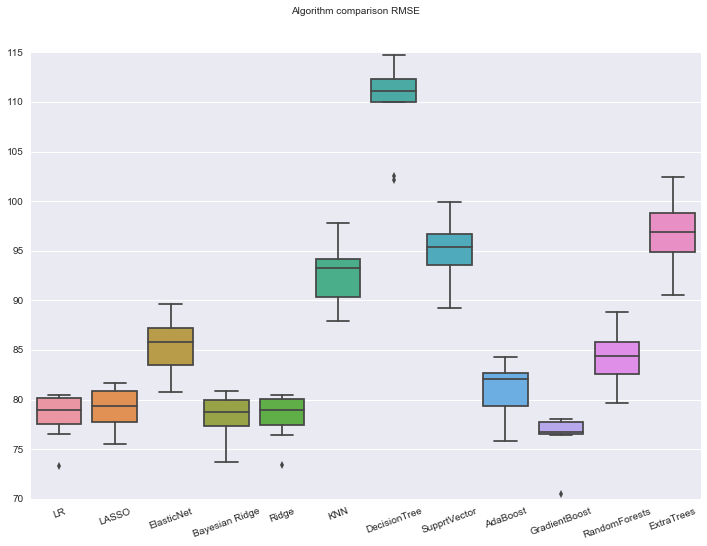

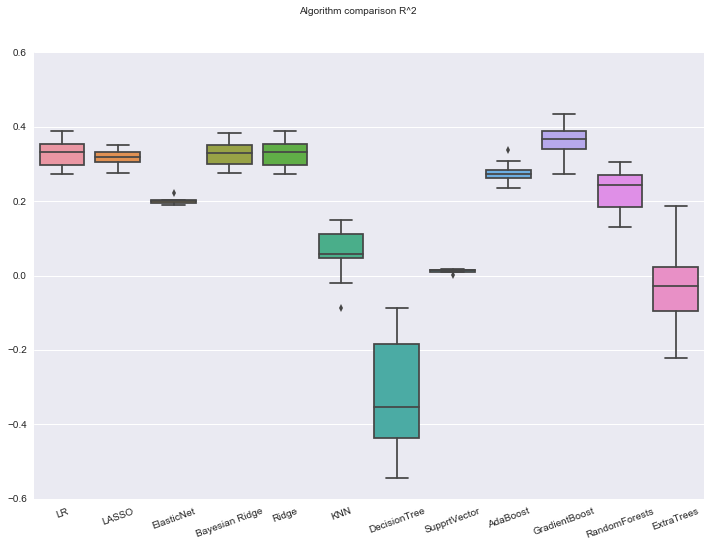

In [86]:
spot_check_models(X_train, y_train)

### Learning curves

### Ridge Regressor

In [ ]:
model  = GradientBoostingRegressor()
kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

print cv_rmse.mean()
print cv_r2.mean()

In [ ]:
model  = GradientBoostingRegressor()
kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

print cv_rmse.mean()
print cv_r2.mean()

### Support Vector Regressor

In [ ]:
### Gradient Boosting Regressor

In [82]:
model  = GradientBoostingRegressor()
kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

print cv_rmse.mean()
print cv_r2.mean()

76.458891876
0.360434229876


### Helper functions

In [62]:
def print_score(y_train, y_pred_train, y_test, y_pred_test):
    '''
    Print the RMSE and R^2 scores for train and test predictions
    '''
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results_list = ['Train', 'Test']
    mae_both =[mae_train, mae_test]
    r2_both = [r2_train, r2_test]
    
    print '\tRMSE\t\tR2'
    for s, mae, r2 in zip(results_list, mae_both, r2_both):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}'.format(s, mae, 2)

In [151]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve2(estimator, title, X, y, ylim=None, cv=None):
    
    plt.figure(figsize=(5,2))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    #train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
    train_sizes = np.linspace(.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    #for size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
    #    print "Train size: %6d, Train Score: %.3f Test Score: %.3f" % (size, train_score, test_score)
    return plt

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

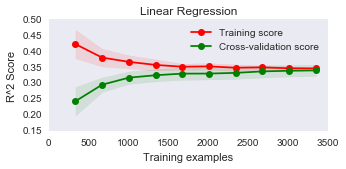

In [152]:
plot_learning_curve2(LinearRegression(), 'Linear Regression', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

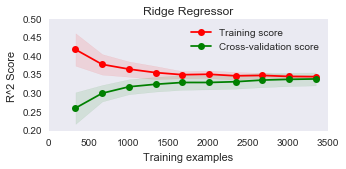

In [153]:
plot_learning_curve2(Ridge(), 'Ridge Regressor', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

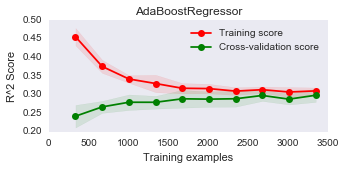

In [159]:
plot_learning_curve2(AdaBoostRegressor(), 'AdaBoostRegressor', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

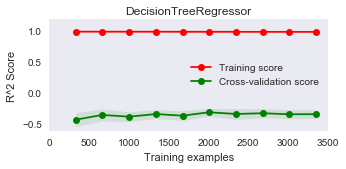

In [155]:
plot_learning_curve2(DecisionTreeRegressor(), 'DecisionTreeRegressor', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

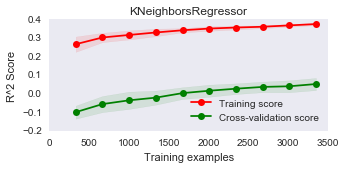

In [156]:
plot_learning_curve2(KNeighborsRegressor(), 'KNeighborsRegressor', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

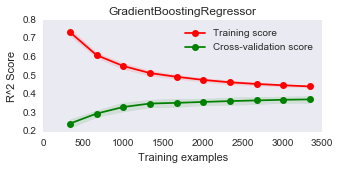

In [157]:
plot_learning_curve2(GradientBoostingRegressor(), 'GradientBoostingRegressor', X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

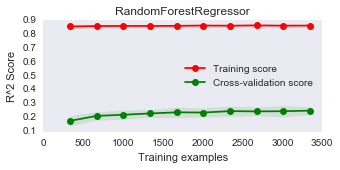

In [158]:
plot_learning_curve2(RandomForestRegressor(), 'RandomForestRegressor', X_train, y_train)

In [ ]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))

In [ ]:
def generate_learningcurves(sparse=False,**kwargs):
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = alg.__class__.__name__
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    alg_name = estimator.__class__.__name__
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt

In [105]:
np.rint(np.linspace(1, X_train.shape[0]*0.8 - 1, 9)).astype(int)

array([   1,  419,  838, 1256, 1674, 2093, 2511, 2929, 3348])

Train size:      1, Train Score: 1.000 Test Score: -0.438
Train size:    419, Train Score: 0.404 Test Score: 0.266
Train size:    838, Train Score: 0.367 Test Score: 0.310
Train size:   1256, Train Score: 0.358 Test Score: 0.321
Train size:   1674, Train Score: 0.351 Test Score: 0.329
Train size:   2093, Train Score: 0.351 Test Score: 0.330
Train size:   2511, Train Score: 0.347 Test Score: 0.334
Train size:   2929, Train Score: 0.347 Test Score: 0.337
Train size:   3348, Train Score: 0.346 Test Score: 0.339


<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

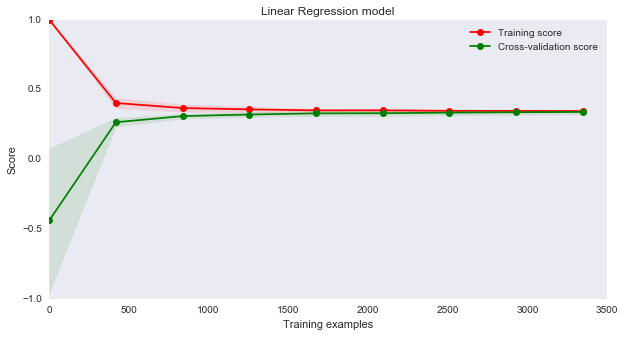

In [119]:
plot_learning_curve2(LinearRegression(), 'Linear Regression model', X_train, y_train)

In [63]:
def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [64]:
def select_hyperparams(**kwargs):
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

Learning Curves Runtime: 0h:00m:09s


Train Size:      33 Train Score: 1.000 Test Score: -0.587
Train Size:     207 Train Score: 1.000 Test Score: -0.486
Train Size:     382 Train Score: 1.000 Test Score: -0.401
Train Size:     556 Train Score: 0.999 Test Score: -0.404
Train Size:     731 Train Score: 0.999 Test Score: -0.400
Train Size:     905 Train Score: 0.999 Test Score: -0.397
Train Size:    1080 Train Score: 0.999 Test Score: -0.349
Train Size:    1254 Train Score: 0.998 Test Score: -0.356
Train Size:    1429 Train Score: 0.998 Test Score: -0.338
Train Size:    1603 Train Score: 0.998 Test Score: -0.358
Train Size:    1777 Train Score: 0.997 Test Score: -0.333
Train Size:    1952 Train Score: 0.997 Test Score: -0.329
Train Size:    2126 Train Score: 0.997 Test Score: -0.324
Train Size:    2301 Train Score: 0.997 Test Score: -0.328
Train Size:    2475 Train Score: 0.997 Test Score: -0.334
Train Size:    2650 Train Score: 0.997 Test Score: -0.323
Train Size:    2824 Train Score: 0

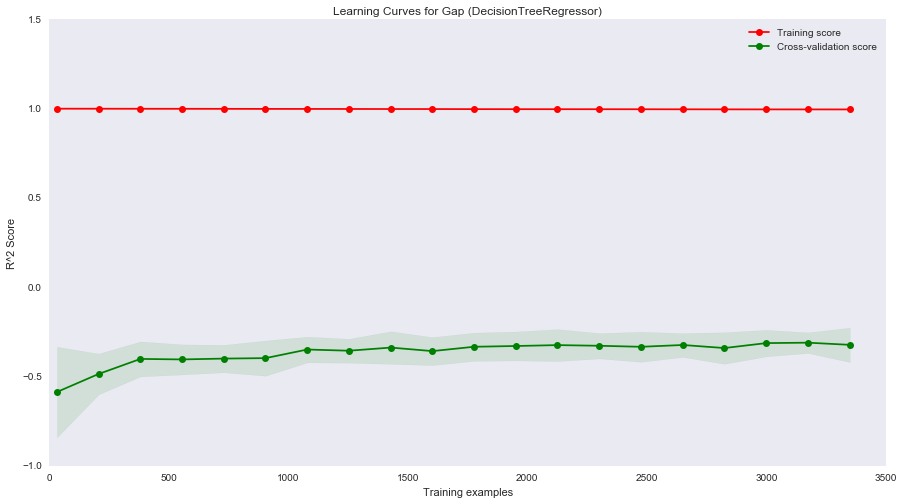

In [65]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
# Random Forests only supports MSE score for deciding splits
generate_learningcurves(gX_train=X_train, gy_train=y_train, alg=DecisionTreeRegressor())

In [66]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_

In [67]:
indices = np.argsort(importances)[::-1]
feature_labels = pisa.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))


 1) schoolSize                     0.153799
 2) expectBachelors                0.140640
 3) minutesPerWeekEnglish          0.121917
 4) studentsInEnglish              0.101623
 5) raceeth_NoRace                 0.068082
 6) read30MinsADay                 0.044255
 7) fatherBachelors                0.034106
 8) male                           0.026644
 9) preschool                      0.022721
10) motherWork                     0.021302
11) computerForSchoolwork          0.018459
12) fatherWork                     0.018022
13) urban                          0.016983
14) fatherHS                       0.014544
15) raceeth_American Indian/Alaska Native 0.013622
16) raceeth_Asian                  0.013503
17) englishAtHome                  0.012924
18) schoolHasLibrary               0.011728
19) motherHS                       0.011582
20) selfBornUS                     0.011527
21) students_<10                   0.009697
22) students_10-20                 0.009678
23) minutes_100-200      

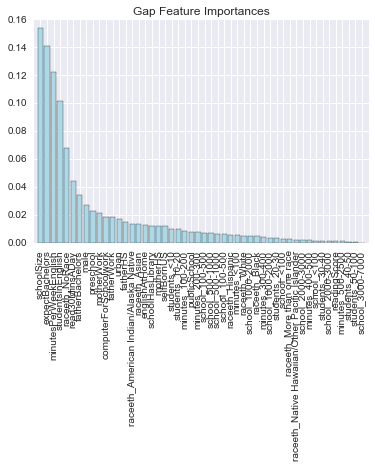

In [68]:
labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Gap Feature Importances')
plt.bar(range(X_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.tight_layout()
plt.show()

In [69]:
indices

array([17,  2, 12, 13, 25, 11,  6,  0,  1,  4, 10,  7, 16,  5, 19, 20,  9,
       14,  3,  8, 33, 34, 28, 15, 29, 40, 41, 47, 46, 22, 27, 26, 48, 21,
       30, 42, 35, 45, 23, 24, 49, 31, 39, 36, 43, 18, 32, 37, 38, 44], dtype=int64)

Learning Curves Runtime: 0h:00m:06s


Train Size:      33 Train Score: 0.678 Test Score: -0.504
Train Size:     207 Train Score: 0.331 Test Score: 0.207
Train Size:     382 Train Score: 0.304 Test Score: 0.238
Train Size:     556 Train Score: 0.289 Test Score: 0.253
Train Size:     731 Train Score: 0.281 Test Score: 0.258
Train Size:     905 Train Score: 0.278 Test Score: 0.263
Train Size:    1080 Train Score: 0.275 Test Score: 0.266
Train Size:    1254 Train Score: 0.272 Test Score: 0.268
Train Size:    1429 Train Score: 0.272 Test Score: 0.270
Train Size:    1603 Train Score: 0.270 Test Score: 0.272
Train Size:    1777 Train Score: 0.269 Test Score: 0.272
Train Size:    1952 Train Score: 0.270 Test Score: 0.272
Train Size:    2126 Train Score: 0.271 Test Score: 0.272
Train Size:    2301 Train Score: 0.270 Test Score: 0.273
Train Size:    2475 Train Score: 0.270 Test Score: 0.273
Train Size:    2650 Train Score: 0.270 Test Score: 0.273
Train Size:    2824 Train Score: 0.269 Test Score

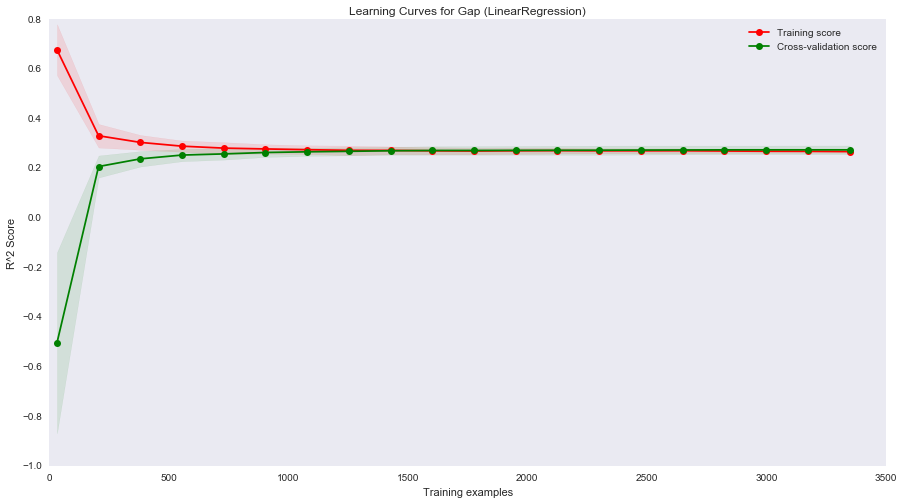

In [70]:
generate_learningcurves(gX_train=X_train[:,[2, 22, 11,  6,  4,  0,  1, 14,  7, 10, 29,  5, 30, 28, 24,  3,  9]], gy_train=y_train, alg=LinearRegression())

In [71]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

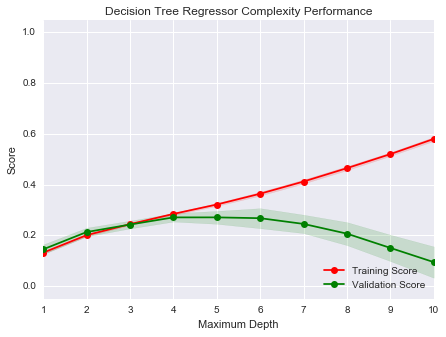

In [72]:
ModelComplexity(X_train, y_train)

In [73]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator=LinearRegression(), cv=10, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
print("Optimal number of features: %d" % selector.n_features_)

Optimal number of features: 49


In [74]:
X_train.shape

(4186L, 50L)

In [75]:
pisa.columns[selector.support_]

C:\Users\Shinto\Anaconda2\lib\site-packages\pandas\indexes\base.py:1404: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
  result = getitem(key)


Index([u'male', u'preschool', u'expectBachelors', u'motherHS', u'motherWork',
       u'fatherHS', u'fatherBachelors', u'fatherWork', u'selfBornUS',
       u'englishAtHome', u'computerForSchoolwork', u'read30MinsADay',
       u'studentsInEnglish', u'schoolHasLibrary', u'publicSchool', u'urban',
       u'schoolSize', u'readingScore',
       u'raceeth_American Indian/Alaska Native', u'raceeth_Asian',
       u'raceeth_Black', u'raceeth_Hispanic', u'raceeth_More than one race',
       u'raceeth_Native Hawaiian/Other Pacific Islander', u'raceeth_NoRace',
       u'raceeth_White', u'minutes_<100', u'minutes_100-200',
       u'minutes_200-300', u'minutes_300-400', u'minutes_400-500',
       u'minutes_500-2500', u'students_<10', u'students_10-20',
       u'students_20-30', u'students_30-40', u'students_40-50',
       u'students_50-100', u'school_<100', u'school_100-500',
       u'school_500-1000', u'school_1000-2000', u'school_2000-3000',
       u'school_3000-7000', u'school_<100', u'school_100-

In [76]:
pisa.columns

Index([u'male', u'preschool', u'expectBachelors', u'motherHS', u'motherWork',
       u'fatherHS', u'fatherBachelors', u'fatherWork', u'selfBornUS',
       u'englishAtHome', u'computerForSchoolwork', u'read30MinsADay',
       u'minutesPerWeekEnglish', u'studentsInEnglish', u'schoolHasLibrary',
       u'publicSchool', u'urban', u'schoolSize', u'readingScore',
       u'raceeth_American Indian/Alaska Native', u'raceeth_Asian',
       u'raceeth_Black', u'raceeth_Hispanic', u'raceeth_More than one race',
       u'raceeth_Native Hawaiian/Other Pacific Islander', u'raceeth_NoRace',
       u'raceeth_White', u'minutes_<100', u'minutes_100-200',
       u'minutes_200-300', u'minutes_300-400', u'minutes_400-500',
       u'minutes_500-2500', u'students_<10', u'students_10-20',
       u'students_20-30', u'students_30-40', u'students_40-50',
       u'students_50-100', u'school_<100', u'school_100-500',
       u'school_500-1000', u'school_1000-2000', u'school_2000-3000',
       u'school_3000-7000', u's

In [77]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [78]:
X_train[:, selector.support_].shape

(4186L, 49L)

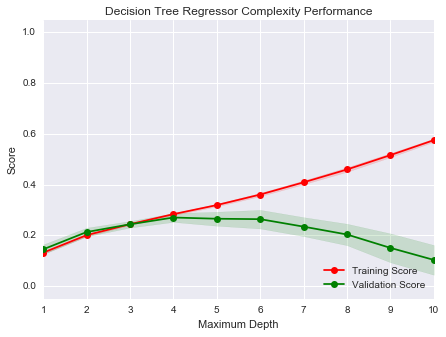

In [79]:
ModelComplexity(X_train[:, selector.support_], y_train)

Learning Curves Runtime: 0h:00m:31s


Train Size:      33 Train Score: 0.924 Test Score: -0.206
Train Size:     207 Train Score: 0.578 Test Score: 0.122
Train Size:     382 Train Score: 0.479 Test Score: 0.186
Train Size:     556 Train Score: 0.426 Test Score: 0.218
Train Size:     731 Train Score: 0.398 Test Score: 0.234
Train Size:     905 Train Score: 0.380 Test Score: 0.246
Train Size:    1080 Train Score: 0.366 Test Score: 0.253
Train Size:    1254 Train Score: 0.357 Test Score: 0.260
Train Size:    1429 Train Score: 0.348 Test Score: 0.264
Train Size:    1603 Train Score: 0.340 Test Score: 0.267
Train Size:    1777 Train Score: 0.334 Test Score: 0.269
Train Size:    1952 Train Score: 0.330 Test Score: 0.271
Train Size:    2126 Train Score: 0.328 Test Score: 0.272
Train Size:    2301 Train Score: 0.324 Test Score: 0.274
Train Size:    2475 Train Score: 0.322 Test Score: 0.275
Train Size:    2650 Train Score: 0.320 Test Score: 0.276
Train Size:    2824 Train Score: 0.317 Test Score

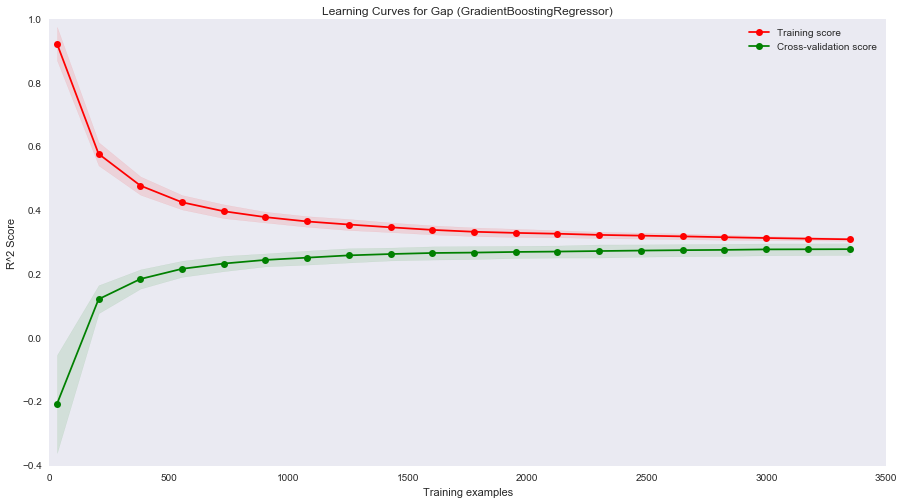

In [80]:
generate_learningcurves(gX_train=X_train[:,[2, 22, 11,  6,  4,  0,  1, 14,  7, 10, 29,  5, 30, 28, 24,  3,  9]], gy_train=y_train, alg=GradientBoostingRegressor())